# Imports

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score,recall_score,roc_auc_score,accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


# Data Reading and Exploration

In [2]:
data=pd.read_csv('fraud_dataset.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
print('Number of Transactions:',data.shape[0])

Number of Transactions: 6362620


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [7]:
data.duplicated().sum()

0

In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# Exploratory Data Analysis

In [9]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: ylabel='count'>

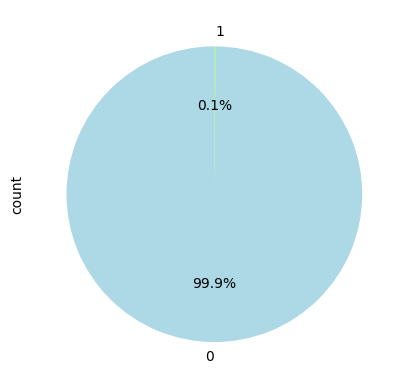

In [10]:
data['isFraud'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = ['#add8e6', '#90ee90'])

(0.0, 5000000.0)

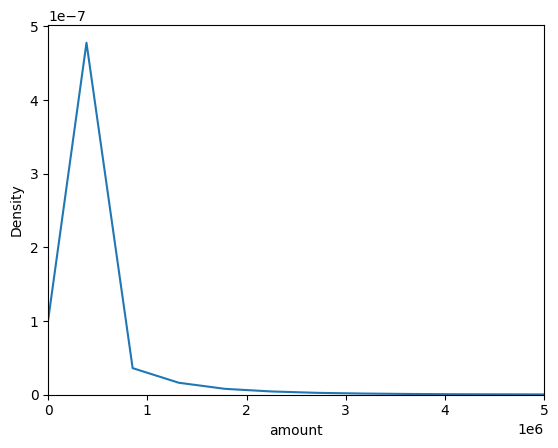

In [11]:
sns.kdeplot(data,x='amount')
plt.xlim(0,5000000)

In [12]:
data['type'].value_counts().sort_values(ascending=False)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

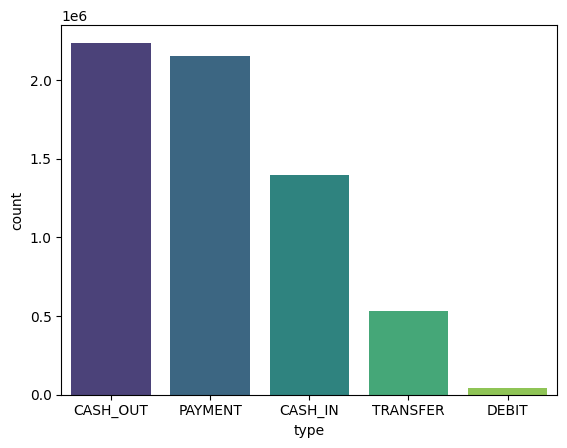

In [13]:
sns.countplot(data=data,x='type',palette='viridis',order=data["type"].value_counts().index)


Most transactions are Cash Out

In [14]:
#data.groupby(['type']).sum()['amount']

In [15]:
data.groupby(['type', 'isFraud']).size().unstack()

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
PAYMENT,2151495.0,NaN
TRANSFER,528812.0,4097.0


<Axes: xlabel='type', ylabel='count'>

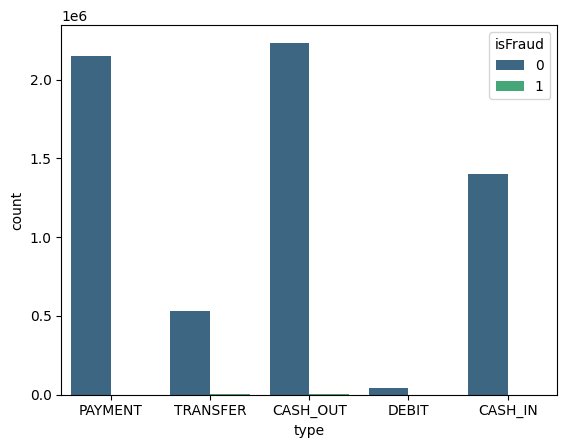

In [16]:
sns.countplot(data=data,x='type',hue='isFraud',palette='viridis')

In [17]:
data.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

<Axes: >

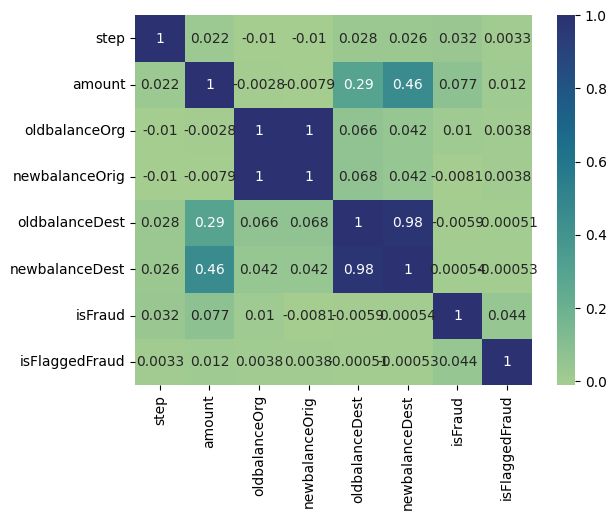

In [18]:
sns.heatmap(data.corr(numeric_only=True),cmap='crest',annot=True)

# Data Pre-Processing

In [19]:
print('Null Values:',data.isnull().sum())

Null Values: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [20]:
print('Any duplicates samples?',data.duplicated().any())

Any duplicates samples? False


No null nor any duplicates.

In [21]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_lower = data[data[column] < lower_bound]
    outliers_upper= data[data[column] > upper_bound]
    return outliers_upper.shape[0],outliers_lower.shape[0]

In [22]:
outliers_upper_count,outliers_lower_count = detect_outliers(data, 'amount')
print(outliers_upper_count,outliers_lower_count)

338078 0


## Feature Engineering and Selection

In [23]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [24]:
data['transactionType'] = data['nameOrig'].str[0] + data['nameDest'].str[0]

In [25]:
data['net_sender'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['net_receiver'] = data['newbalanceDest'] - data['oldbalanceDest']

In [26]:
data=data.drop(['nameOrig','nameDest',"isFlaggedFraud"],axis=1)

In [27]:
data.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

isFraud           1.000000
net_sender        0.362472
amount            0.076688
step              0.031578
net_receiver      0.027028
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [28]:
sender_correlation = data.corr(numeric_only=True)['net_sender'].sort_values(ascending=False)
print(sender_correlation.abs())

net_sender        1.000000
isFraud           0.362472
net_receiver      0.169292
amount            0.102337
step              0.007255
newbalanceDest    0.006451
oldbalanceDest    0.047460
oldbalanceOrg     0.220297
newbalanceOrig    0.267750
Name: net_sender, dtype: float64


In [29]:
data=data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1)

In [30]:
data['transactionType'].unique()

array(['CM', 'CC'], dtype=object)

# Encoding

In [31]:
"""encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data["type"])
data['transactionType']=encoder.fit_transform(data['transactionType'])"""

data_onehot = pd.get_dummies(data, columns=['transactionType', 'type'], drop_first=True)
#or one hot

In [42]:
col=data_onehot.pop('isFraud')
data_onehot['isFraud']=col
data_onehot.head()

,step,amount,net_sender,net_receiver,transactionType_CM,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,1,9839.64,9839.64,0.0,True,False,False,True,False,0
1,1,1864.28,1864.28,0.0,True,False,False,True,False,0
2,1,181.00,181.00,0.0,False,False,False,False,True,1
3,1,181.00,181.00,-21182.0,False,True,False,False,False,1
4,1,11668.14,11668.14,0.0,True,False,False,True,False,0


# Train Test Split

In [43]:
from sklearn.model_selection import train_test_split
# 1. 分割正常交易数据和欺诈数据
normal_data = data_onehot[data_onehot["isFraud"] == 0]
fraud_data = data_onehot[data_onehot["isFraud"] == 1]

# 2. 分别划分正常数据和欺诈数据
# 正常数据
normal_train, normal_temp = train_test_split(normal_data, test_size=0.4, random_state=42)  # 60% 训练集
normal_val, normal_test = train_test_split(normal_temp, test_size=0.5, random_state=42)    # 20% 验证集，20% 测试集
# 欺诈数据
fraud_train, fraud_temp = train_test_split(fraud_data, test_size=0.4, random_state=42)  # 60% 训练集
fraud_val, fraud_test = train_test_split(fraud_temp, test_size=0.5, random_state=42)    # 20% 验证集，20% 测试集
# concat the validation and test data
val_data = pd.concat([normal_val, fraud_val])
test_data = pd.concat([normal_test, fraud_test])
# shuffle the order of data
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
# split the target data and validation data of validation and test 
X_val = val_data.drop(columns=["isFraud"])
y_val = val_data["isFraud"]
X_test = test_data.drop(columns=["isFraud"])
y_test = test_data["isFraud"]


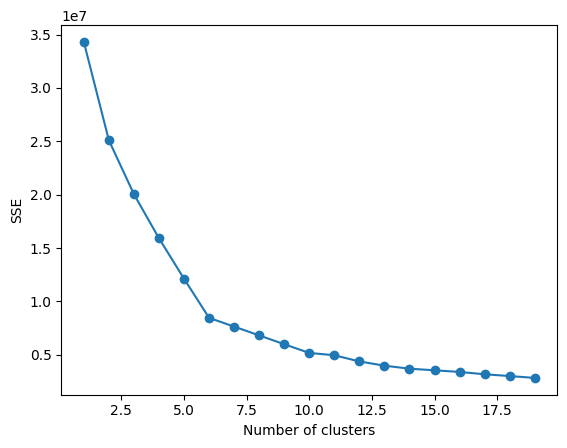

In [44]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# 数据标准化
fraud = fraud_train
scaler = StandardScaler()
normal_train_scaled = scaler.fit_transform(normal_train.iloc[:, :-1])

# 使用肘部法选择聚类数量
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normal_train_scaled)
    sse.append(kmeans.inertia_)

# 绘制肘部法图
import matplotlib.pyplot as plt
plt.plot(range(1, 20), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [50]:
clusters = 5 # chose the best clusters from elbow figure
kmeans = KMeans(n_clusters=clusters, random_state=42, init='k-means++', n_init=5)
normal_train_clusters = kmeans.fit_predict(normal_train_scaled)
ratio_options=[0.001,0.002,0.005,0.01,0.02,0.05]
train_data_total=[]
# 存储最优的 non_fraud 样本
for ratio in ratio_options:
    total_samples = int(len(fraud) / ratio)  # 确保 total_samples 是整数
    samples_per_cluster = total_samples // clusters # 每类抽取的样本数
    # 从每个聚类中抽取样本
    non_fraud = pd.DataFrame()
    for cluster in range(clusters):
        cluster_samples = normal_train[normal_train_clusters == cluster]
        # 如果某个聚类样本数小于样本抽取数，使用全部样本
        non_fraud = pd.concat([non_fraud, cluster_samples.sample(n=samples_per_cluster,replace=True)])  
    # Combine fraud and non-fraud samples
    train_data = pd.concat([fraud, non_fraud])
    train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
    train_data_total.append(train_data)
    print(f"Ratio: {ratio}, Non-fraud samples: {len(non_fraud)}, Fraud samples: {len(fraud)}, Total samples: {len(train_data)}")

# 输出结果
for i, ratio in enumerate(ratio_options):
    print(f"Training set for ratio {ratio}: {len(train_data_total[i])} samples")

Ratio: 0.001, Non-fraud samples: 4927000, Fraud samples: 4927, Total samples: 4931927
Ratio: 0.002, Non-fraud samples: 2463500, Fraud samples: 4927, Total samples: 2468427
Ratio: 0.005, Non-fraud samples: 985400, Fraud samples: 4927, Total samples: 990327
Ratio: 0.01, Non-fraud samples: 492700, Fraud samples: 4927, Total samples: 497627
Ratio: 0.02, Non-fraud samples: 246350, Fraud samples: 4927, Total samples: 251277
Ratio: 0.05, Non-fraud samples: 98540, Fraud samples: 4927, Total samples: 103467
Training set for ratio 0.001: 4931927 samples
Training set for ratio 0.002: 2468427 samples
Training set for ratio 0.005: 990327 samples
Training set for ratio 0.01: 497627 samples
Training set for ratio 0.02: 251277 samples
Training set for ratio 0.05: 103467 samples


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

Define Validation Evaluation function

In [51]:
def validation_evaluate_model(model, X_val, y_val):
    # 预测
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # 预测概率（用于 ROC-AUC）

    # 计算指标
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # 输出结果
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # 绘制 ROC 曲线
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return accuracy, precision, recall, f1, roc_auc



Training and evaluating model for ratio 0.001
Accuracy: 0.9996
Precision: 0.9326
Recall: 0.7669
F1 Score: 0.8417
ROC-AUC: 0.9567


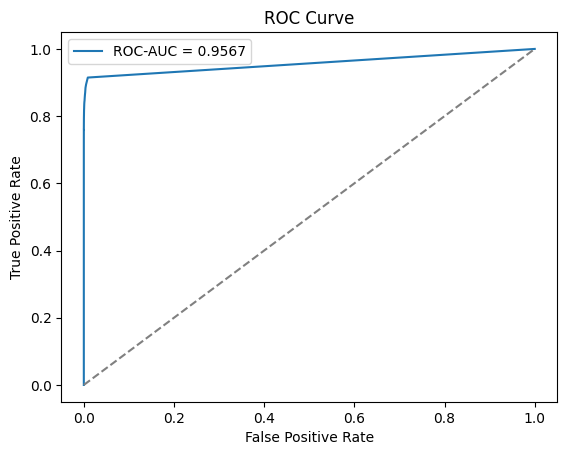


Training and evaluating model for ratio 0.002
Accuracy: 0.9996
Precision: 0.8824
Recall: 0.7809
F1 Score: 0.8285
ROC-AUC: 0.9619


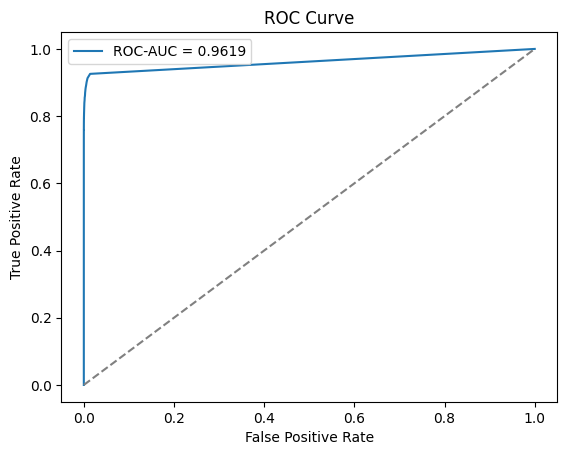


Training and evaluating model for ratio 0.005
Accuracy: 0.9993
Precision: 0.7062
Recall: 0.8077
F1 Score: 0.7535
ROC-AUC: 0.9739


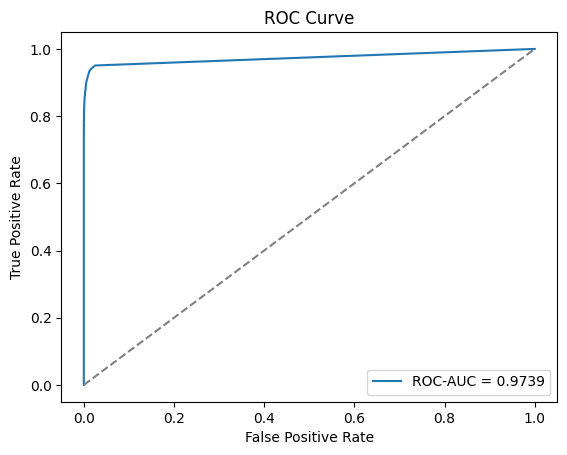


Training and evaluating model for ratio 0.01
Accuracy: 0.9989
Precision: 0.5405
Recall: 0.8332
F1 Score: 0.6557
ROC-AUC: 0.9805


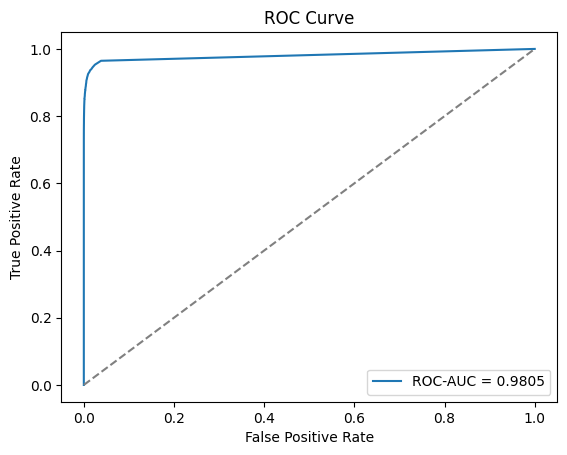


Training and evaluating model for ratio 0.02
Accuracy: 0.9977
Precision: 0.3468
Recall: 0.8582
F1 Score: 0.4940
ROC-AUC: 0.9861


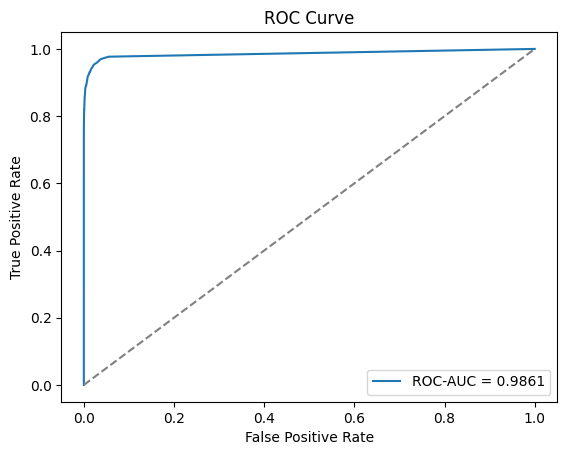


Training and evaluating model for ratio 0.05
Accuracy: 0.9946
Precision: 0.1790
Recall: 0.8886
F1 Score: 0.2979
ROC-AUC: 0.9919


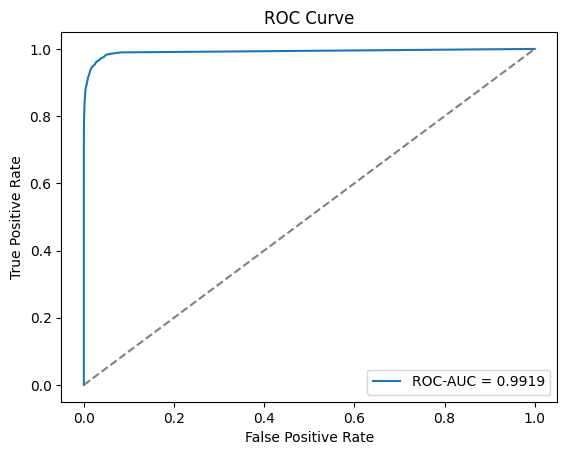


Validation set results:
Ratio: 0.001, Accuracy: 0.9996, Precision: 0.9326, Recall: 0.7669, F1 Score: 0.8417, ROC-AUC: 0.9567
Ratio: 0.002, Accuracy: 0.9996, Precision: 0.8824, Recall: 0.7809, F1 Score: 0.8285, ROC-AUC: 0.9619
Ratio: 0.005, Accuracy: 0.9993, Precision: 0.7062, Recall: 0.8077, F1 Score: 0.7535, ROC-AUC: 0.9739
Ratio: 0.01, Accuracy: 0.9989, Precision: 0.5405, Recall: 0.8332, F1 Score: 0.6557, ROC-AUC: 0.9805
Ratio: 0.02, Accuracy: 0.9977, Precision: 0.3468, Recall: 0.8582, F1 Score: 0.4940, ROC-AUC: 0.9861
Ratio: 0.05, Accuracy: 0.9946, Precision: 0.1790, Recall: 0.8886, F1 Score: 0.2979, ROC-AUC: 0.9919


In [52]:
# 假设 X_val 和 y_val 是验证集的特征和标签
validation_results = []

for i, train_data in enumerate(train_data_total):
    print(f"\nTraining and evaluating model for ratio {ratio_options[i]}")

    # 划分特征和标签
    X_train = train_data.iloc[:, :-1]  # 特征
    y_train = train_data.iloc[:, -1]   # 标签

    # 训练随机森林模型
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # 在验证集上评估模型
    accuracy, precision, recall, f1, roc_auc = validation_evaluate_model(model, X_val, y_val)

    # 存储结果
    validation_results.append({
        "ratio": ratio_options[i],
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

# 输出验证集结果
print("\nValidation set results:")
for result in validation_results:
    print(f"Ratio: {result['ratio']}, "
          f"Accuracy: {result['accuracy']:.4f}, "
          f"Precision: {result['precision']:.4f}, "
          f"Recall: {result['recall']:.4f}, "
          f"F1 Score: {result['f1']:.4f}, "
          f"ROC-AUC: {result['roc_auc']:.4f}")

In [ ]:
# 假设 X_test 和 y_test 是测试集的特征和标签
results = []

for i, train_data in enumerate(train_data_total):
    print(f"\nTraining and evaluating model for ratio {ratio_options[i]}")

    # 划分特征和标签
    X_train = train_data.iloc[:, :-1]  # 特征
    y_train = train_data.iloc[:, -1]   # 标签

    # 训练随机森林模型
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # 评估模型
    accuracy, precision, recall, f1, roc_auc = evaluate_model(model, X_test, y_test)

    # 存储结果
    results.append({
        "ratio": ratio_options[i],
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    })

# 输出所有结果
print("\nSummary of results:")
for result in results:
    print(f"Ratio: {result['ratio']}, "
          f"Accuracy: {result['accuracy']:.4f}, "
          f"Precision: {result['precision']:.4f}, "
          f"Recall: {result['recall']:.4f}, "
          f"F1 Score: {result['f1']:.4f}, "
          f"ROC-AUC: {result['roc_auc']:.4f}")

In [36]:
fffffff
# Combine fraud and non-fraud samples
train_data = pd.concat([fraud, non_fraud])
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

NameError: name 'fffffff' is not defined

In [ ]:
X_train = train_data.drop("isFraud",axis=1)
y_train = train_data["isFraud"]

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [ ]:
y_train.value_counts()

isFraud
0    295600
1      4927
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

isFraud
0    1270882
1       1643
Name: count, dtype: int64

In [ ]:
'''from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

hybrid = SMOTE(sampling_strategy=0.8, random_state=42)  # 10% fraud to non-fraud
X_train, y_train = hybrid.fit_resample(X_train, y_train)'''

'''from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.86, random_state=42)  # Keep 10% of non-fraud
X_train, y_train = undersample.fit_resample(X_train, y_train)'''

'from imblearn.under_sampling import RandomUnderSampler\nundersample = RandomUnderSampler(sampling_strategy=0.86, random_state=42)  # Keep 10% of non-fraud\nX_train, y_train = undersample.fit_resample(X_train, y_train)'

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SGD Classifier": SGDClassifier(n_jobs=-1),
    #"Support Vector Classifier": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    # "XGBoost": XGBClassifier(eval_metric="logloss"),
    # "CatBoost": CatBoostClassifier(verbose=0),
    # "LightGBM": LGBMClassifier(n_jobs=-1)
}   
results= []    

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    })

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       0.71      0.37      0.49      1643

    accuracy                           1.00   1272525
   macro avg       0.86      0.69      0.75   1272525
weighted avg       1.00      1.00      1.00   1272525

Classification Report for SGD Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      0.19      0.31      1643

    accuracy                           1.00   1272525
   macro avg       1.00      0.59      0.66   1272525
weighted avg       1.00      1.00      1.00   1272525

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270882
           1       0.10      0.84      0.19      1643

    accuracy                           0.99   127

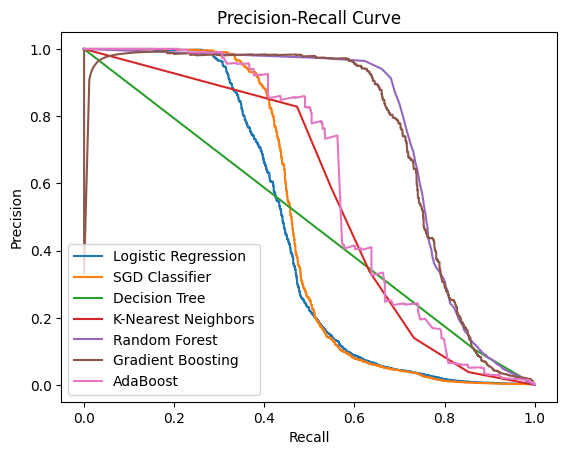

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score,roc_curve,auc
import numpy as np
import matplotlib.pyplot as plt 

for name, model in models.items():
    if isinstance(model, SGDClassifier) and model.loss == 'hinge':
        # 使用 decision_function()
        y_val_decision = model.decision_function(X_val)
        # 使用 decision_function() 替代 predict_proba()，并修改后续的 precision_recall_curve 调用
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_decision)
    else:
        # 使用 predict_proba()
        y_val_pro = model.predict_proba(X_val)[:, 1]  # positive result
        precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pro)

    # 绘制 precision_recall_curve
    plt.plot(recalls, precisions, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(13,activation='relu'))
model.add(Dense(7,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',patience=4)

In [ ]:
history=model.fit(
    x=X_train,
    y=y_train,
    epochs=25,
    validation_data=(X_test,y_test),
    batch_size=256,
    callbacks=[early_stop]
)

Epoch 1/25
1168/1174 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9603

KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(history.history)
losses

,accuracy,loss,val_accuracy,val_loss
0,0.997196,0.007892,0.997455,0.007054
1,0.997216,0.007870,0.997335,0.007467
2,0.997211,0.007858,0.997465,0.007773
3,0.997121,0.007957,0.997385,0.006942
4,0.997196,0.007706,0.997046,0.007178
5,0.997315,0.007514,0.997525,0.006825
6,0.997318,0.007443,0.997375,0.006717
7,0.997345,0.007444,0.996417,0.009629
8,0.997263,0.007504,0.997625,0.006501
9,0.997368,0.007341,0.997575,0.007318


<Axes: >

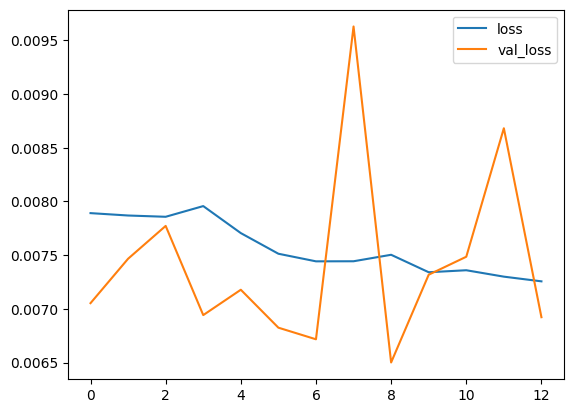

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
predictions=model.predict(X_test)
predictions=(predictions>0.5).astype(int)

3132/3132 ━━━━━━━━━━━━━━━━━━━━ 2s 555us/step


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98617
           1       0.94      0.92      0.93      1582

    accuracy                           1.00    100199
   macro avg       0.97      0.96      0.96    100199
weighted avg       1.00      1.00      1.00    100199



In [ ]:
results.append({
        'Model': 'ANN',
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'ROC-AUC': roc_auc_score(y_test, predictions)
    })

In [ ]:
summary=pd.DataFrame(results)
summary=summary.reindex()
summary.sort_values(by='Recall',ascending=False)

,Model,Accuracy,Precision,Recall,ROC-AUC
8,CatBoost,0.998892,0.968173,0.961441,0.980467
9,LightGBM,0.998214,0.930632,0.958281,0.978567
7,XGBoost,0.998832,0.968650,0.957016,0.978260
2,Decision Tree,0.998243,0.946066,0.942478,0.970808
4,Random Forest,0.998423,0.966579,0.932364,0.965923
12,ANN,0.997794,0.939884,0.919090,0.959073
5,Gradient Boosting,0.997585,0.965278,0.878635,0.939064
3,K-Nearest Neighbors,0.996208,0.932997,0.818584,0.908821
6,AdaBoost,0.995599,0.920413,0.789507,0.894206
0,Logistic Regression,0.993613,0.926630,0.646650,0.822914
